In [2]:
%load_ext autoreload
%autoreload 2
from config import MARKET_MODEL_DIR,MARKET_MODEL_DIR_TESTING
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pickle
with open(MARKET_MODEL_DIR, "rb") as f:
    params = pickle.load(f)

with open(MARKET_MODEL_DIR_TESTING, "rb") as f:
    params_testing = pickle.load(f)
    
import os
#个人许可证
#os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")


# ## 系统Gurobi
os.environ['GUROBI_HOME'] = '/usr/licensed/gurobi/12.0.0/linux64'
os.environ['GRB_LICENSE_FILE'] = '/usr/licensed/gurobi/license/gurobi.lic'

# 清除个人WLS许可证
for var in ['WLSACCESSID', 'WLSSECRET']:
    if var in os.environ:
        del os.environ[var]

model = build_market_neutral_model(**params)
model_testing= build_market_neutral_model_testing(**params_testing)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from io_utils import load_dataset_dict, create_dataset_from_dict
from config import DATASET_DICT_PATH, TEST_DATASET_DICT_PATH
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset_train = create_dataset_from_dict(dataset_dict, model)
test_dataset_dict = load_dataset_dict(TEST_DATASET_DICT_PATH)
dataset_test = create_dataset_from_dict(test_dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.
>>> Precomputed mode enabled. Skipping time series processing and solution computation.


# 可选模型的信息
#  model_info = {
        'TCN': {
            # 训练配置
            'use_mixed_precision': True,
            'gradient_clip_norm': None,
            'training_reason': 'TCN架构稳定，无需梯度裁剪。混合精度加速训练。',
            
            # 推荐条件
            'recommend_when': [
                ('sequence_length > 200', '长序列，TCN处理效率最高'),
                ('50 <= sequence_length <= 200', '中等长度序列的最佳选择'),
                ('computational_budget == "medium"', '平衡性能和资源消耗'),
                ('prefer_speed == True', '训练速度快，并行化好'),
            ],
            
            # 适用场景
            'best_for': [
                '长时间序列预测',
                '实时推理场景',
                '需要快速训练的项目',
                'GPU资源充足的环境'
            ],
            
            # 优势
            'advantages': [
                '✅ 梯度稳定，几乎不会爆炸/消失',
                '✅ 并行训练，速度快',
                '✅ 感受野可控，能捕获长期依赖',
                '✅ 架构成熟，调参简单'
            ],
            
            # 劣势
            'disadvantages': [
                '⚠️ 参数量相对较多',
                '⚠️ 对短序列可能过拟合'
            ]
        },
        
        'DLinear': {
            # 训练配置
            'use_mixed_precision': gpu_memory_gb < 8 or prefer_speed,
            'gradient_clip_norm': None,
            'training_reason': 'DLinear极简稳定。小GPU推荐混合精度节省内存。',
            
            # 推荐条件
            'recommend_when': [
                ('has_trend and has_seasonality', '数据有明显的趋势和季节性模式'),
                ('sequence_length < 50', '短序列，简单模型可能更有效'),
                ('computational_budget == "low"', '计算资源有限'),
                ('prefer_speed == True', '极快的训练和推理速度'),
            ],
            
            # 适用场景
            'best_for': [
                '有明显趋势的时间序列',
                '计算资源受限的环境',
                '需要可解释性的场景',
                '作为强基线模型'
            ],
            
            # 优势
            'advantages': [
                '✅ 极简架构，几乎不会过拟合',
                '✅ 训练超快，参数量少',
                '✅ 对趋势和季节性敏感',
                '✅ 可解释性强',
                '✅ 内存占用极少'
            ],
            
            # 劣势
            'disadvantages': [
                '⚠️ 对复杂非线性模式建模能力有限',
                '⚠️ 可能在复杂数据上表现不佳'
            ]
        },
        
        'Transformer': {
            # 训练配置
            'use_mixed_precision': True,
            'gradient_clip_norm': 1.0,
            'training_reason': 'Transformer计算密集，强烈推荐混合精度。轻微梯度裁剪保险。',
            
            # 推荐条件
            'recommend_when': [
                ('computational_budget == "high" and sequence_length < 200', '充足资源且序列不太长'),
                ('need_attention == True', '需要注意力机制和解释性'),
                ('complex_patterns == True', '数据有复杂的长期依赖关系'),
            ],
            
            # 适用场景
            'best_for': [
                '需要注意力可视化的场景',
                '复杂的多变量时间序列',
                '研究和实验项目',
                '对精度要求极高的场景'
            ],
            
            # 优势
            'advantages': [
                '✅ 强大的序列建模能力',
                '✅ 注意力机制提供解释性',
                '✅ 能捕获复杂的长期依赖',
                '✅ 在复杂数据上表现优秀'
            ],
            
            # 劣势
            'disadvantages': [
                '⚠️ 计算复杂度O(n²)',
                '⚠️ 参数量大，容易过拟合',
                '⚠️ 对长序列内存消耗大',
                '⚠️ 需要更多调参'
            ]
        },
        
        'CNN-Attention': {
            # 训练配置
            'use_mixed_precision': True,
            'gradient_clip_norm': 0.5,
            'training_reason': '混合架构，推荐保守的梯度裁剪配置。',
            
            # 推荐条件
            'recommend_when': [
                ('need_local_and_global == True', '需要同时捕获局部和全局特征'),
                ('computational_budget == "medium"', '中等计算资源'),
                ('experimental == True', '实验性尝试'),
            ],
            
            # 适用场景
            'best_for': [
                '局部和全局特征都重要的数据',
                '实验和研究项目',
                '需要平衡性能的场景'
            ],
            
            # 优势
            'advantages': [
                '✅ 结合CNN和Attention优势',
                '✅ 对局部模式敏感',
                '✅ 有一定的全局建模能力'
            ],
            
            # 劣势
            'disadvantages': [
                '⚠️ 架构复杂，调参困难',
                '⚠️ 可能不如专门的模型',
                '⚠️ 训练稳定性一般'
            ]
        }
    }

In [4]:
%load_ext autoreload
%autoreload 2
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM, TCNModel, DLinear, LightTransformer,CNNAttentionModel
from seed import set_seed

set_seed(42)

"""
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)
    
"""
    

#长序列，TCN处理效率最高
lstm = TCNModel(k=K, hidden_dim=HIDDEN_DIM, num_layers=4, dropout_rate=DROPOUT_RATE).to(DEVICE)

"""
# 选项2：DLinear (数据有规律模式时)
set_seed(42)
lstm = DLinear(k=K, lookback=LOOKBACK, individual=True).to(DEVICE)

# 选项3：Transformer (中等长度序列)
set_seed(42)
lstm = LightTransformer(k=K, d_model=HIDDEN_DIM, nhead=4, num_layers=2, dropout_rate=DROPOUT_RATE).to(DEVICE)


# 选项4:CNN-Attention
lstm = CNNAttentionModel(
        k=K, 
        hidden_dim=HIDDEN_DIM, 
        num_heads=4,            # 注意力头数
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
"""
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seed set to 42
Model architecture:
tcn_layers.0.conv1.weight      | Shape: torch.Size([32, 21, 3]) | Parameters: 2016 | require_grad: True
Mean Value: -0.0015308154979720712 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv1.bias        | Shape: torch.Size([32]) | Parameters: 32 | require_grad: True
Mean Value: -0.0037392256781458855 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv2.weight      | Shape: torch.Size([32, 32, 3]) | Parameters: 3072 | require_grad: True
Mean Value: 0.0002577386039774865 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv2.bias        | Shape: torch.Size([32]) | Parameters: 32 | require_grad: True
Mean Value: 0.010295314714312553 | Grad: None
-----------------------------------------------

In [5]:
from data_loader import get_data_loaders
# 创建 Subset 类
from torch.utils.data import DataLoader
from config import BATCH_SIZE
# 假设 dataset_train, dataset_test 都是 optDataset 的实例
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_test  = DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

loss_log=[]
loss_log_regret=[]

In [5]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=False,# Adjusted learning rate,
    scaler= False
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets_TCN.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [04:12<00:00, 51.91it/s, loss=0.0000, batch time=0.0248s] 
Testing Regret: 3276batch [00:57, 57.16batch/s]


Epoch 1: Loss=0.000000, Regret=91.4531%, Time=309.78s


Epoch 2/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.79it/s, loss=0.0000, batch time=0.0358s] 
Testing Regret: 3276batch [00:50, 64.50batch/s]


Epoch 2: Loss=0.000000, Regret=91.4653%, Time=281.56s


Epoch 3/3: 100%|██████████| 13101/13101 [03:46<00:00, 57.92it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:54, 59.81batch/s]


Epoch 3: Loss=0.000000, Regret=91.4831%, Time=280.98s
Total training time: 872.32s, Effective computation time: 516.43s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt


In [ ]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

for i in range(100):

    print( f"第{i+1}次训练") 

    set_seed(42)
    
    spop = pyepo.func.SPOPlus(model)
    loss_log, loss_log_regret = trainModel(
        lstm, 
        loss_func=spop, 
        method_name="spo+",
        loader_train=loader_train,
        loader_test=loader_test,
        market_neutral_model=model,
        params_testing=params_testing,
        loss_log=loss_log, 
        loss_log_regret=loss_log_regret,
        num_epochs=NUM_EPOCHS,  # Increased for better convergence
        lr=LR,
        initial=False,# Adjusted learning rate,
        scaler= False
    )
    
    lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets_TCN.pt")
    torch.save({
        'model_state_dict': lstm.state_dict(),
        'loss_log': loss_log,
        'loss_log_regret': loss_log_regret
    }, lstm_save_path)
    
    print(f"模型参数已保存到 {lstm_save_path}")

第1次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:47<00:00, 57.57it/s, loss=0.0000, batch time=0.0194s] 
Testing Regret: 3276batch [00:51, 63.51batch/s]


Epoch 1: Loss=0.000000, Regret=91.4856%, Time=279.22s


Epoch 2/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.74it/s, loss=0.0000, batch time=0.0195s] 
Testing Regret: 3276batch [00:51, 63.07batch/s]


Epoch 2: Loss=0.000000, Regret=91.4617%, Time=282.95s


Epoch 3/3: 100%|██████████| 13101/13101 [03:49<00:00, 57.20it/s, loss=0.0000, batch time=0.0092s] 
Testing Regret: 3276batch [00:51, 63.49batch/s]


Epoch 3: Loss=0.000000, Regret=91.4800%, Time=280.66s
Total training time: 842.83s, Effective computation time: 488.16s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第2次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:47<00:00, 57.60it/s, loss=0.0000, batch time=0.0246s] 
Testing Regret: 3276batch [00:54, 60.37batch/s]


Epoch 1: Loss=0.000000, Regret=91.4880%, Time=281.74s


Epoch 2/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.25it/s, loss=0.0000, batch time=0.0332s] 
Testing Regret: 3276batch [00:58, 55.61batch/s]


Epoch 2: Loss=0.000000, Regret=91.4792%, Time=287.74s


Epoch 3/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.10it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:56, 57.95batch/s]


Epoch 3: Loss=0.000000, Regret=91.4733%, Time=290.13s
Total training time: 859.61s, Effective computation time: 491.90s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第3次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:49<00:00, 57.11it/s, loss=0.0000, batch time=0.0090s] 
Testing Regret: 3276batch [00:53, 61.73batch/s]


Epoch 1: Loss=0.000000, Regret=91.4980%, Time=282.48s


Epoch 2/3: 100%|██████████| 13101/13101 [03:51<00:00, 56.64it/s, loss=0.0000, batch time=0.0154s] 
Testing Regret: 3276batch [00:52, 62.29batch/s]


Epoch 2: Loss=0.000000, Regret=91.4042%, Time=283.92s


Epoch 3/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.91it/s, loss=0.0000, batch time=0.0089s] 
Testing Regret: 3276batch [00:54, 60.39batch/s]


Epoch 3: Loss=0.000000, Regret=91.5309%, Time=284.44s
Total training time: 850.84s, Effective computation time: 488.17s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第4次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:54<00:00, 55.82it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:56, 57.67batch/s]


Epoch 1: Loss=0.000000, Regret=91.5233%, Time=291.52s


Epoch 2/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.28it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:57, 56.54batch/s]


Epoch 2: Loss=0.000000, Regret=91.4470%, Time=290.74s


Epoch 3/3: 100%|██████████| 13101/13101 [03:58<00:00, 54.85it/s, loss=0.0000, batch time=0.0094s] 
Testing Regret: 3276batch [00:51, 63.47batch/s]


Epoch 3: Loss=0.000000, Regret=91.5131%, Time=290.49s
Total training time: 872.75s, Effective computation time: 486.96s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第5次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.42it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:51, 63.92batch/s]


Epoch 1: Loss=0.000000, Regret=91.5533%, Time=283.46s


Epoch 2/3: 100%|██████████| 13101/13101 [03:49<00:00, 57.12it/s, loss=0.0000, batch time=0.0247s] 
Testing Regret: 3276batch [00:51, 63.84batch/s]


Epoch 2: Loss=0.000000, Regret=91.4045%, Time=280.67s


Epoch 3/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.72it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:53, 61.16batch/s]


Epoch 3: Loss=0.000000, Regret=91.5154%, Time=284.55s
Total training time: 848.67s, Effective computation time: 488.94s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第6次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:47<00:00, 57.49it/s, loss=0.0000, batch time=0.0277s] 
Testing Regret: 3276batch [00:54, 59.69batch/s]


Epoch 1: Loss=0.000000, Regret=91.4817%, Time=282.82s


Epoch 2/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.40it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:55, 59.55batch/s]


Epoch 2: Loss=0.000000, Regret=91.3666%, Time=287.34s


Epoch 3/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.16it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:51, 64.07batch/s]


Epoch 3: Loss=0.000000, Regret=91.4632%, Time=284.41s
Total training time: 854.57s, Effective computation time: 488.25s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第7次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.14it/s, loss=0.0000, batch time=0.0153s] 
Testing Regret: 3276batch [00:51, 63.73batch/s]


Epoch 1: Loss=0.000000, Regret=91.4946%, Time=284.77s


Epoch 2/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.41it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:51, 63.04batch/s]


Epoch 2: Loss=0.000000, Regret=91.3893%, Time=280.26s


Epoch 3/3: 100%|██████████| 13101/13101 [04:01<00:00, 54.31it/s, loss=0.0000, batch time=0.0088s] 
Testing Regret: 3276batch [00:55, 59.53batch/s]


Epoch 3: Loss=0.000000, Regret=91.5291%, Time=296.26s
Total training time: 861.29s, Effective computation time: 490.26s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第8次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:54<00:00, 55.91it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:52, 62.11batch/s]


Epoch 1: Loss=0.000000, Regret=91.4379%, Time=287.11s


Epoch 2/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.82it/s, loss=0.0000, batch time=0.0243s] 
Testing Regret: 3276batch [00:56, 57.97batch/s]


Epoch 2: Loss=0.000000, Regret=91.4484%, Time=287.07s


Epoch 3/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.79it/s, loss=0.0000, batch time=0.0089s] 
Testing Regret: 3276batch [00:51, 63.07batch/s]


Epoch 3: Loss=0.000000, Regret=91.5113%, Time=282.63s
Total training time: 856.81s, Effective computation time: 487.08s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第9次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:51<00:00, 56.53it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:58, 55.67batch/s]


Epoch 1: Loss=0.000000, Regret=91.4051%, Time=290.60s


Epoch 2/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.14it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:52, 62.77batch/s]


Epoch 2: Loss=0.000000, Regret=91.3471%, Time=285.64s


Epoch 3/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.43it/s, loss=0.0000, batch time=0.0106s] 
Testing Regret: 3276batch [00:52, 62.98batch/s]


Epoch 3: Loss=0.000000, Regret=91.5058%, Time=280.12s
Total training time: 856.36s, Effective computation time: 485.29s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第10次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.28it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:54, 60.51batch/s]


Epoch 1: Loss=0.000000, Regret=91.3913%, Time=286.92s


Epoch 2/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.16it/s, loss=0.0000, batch time=0.0088s] 
Testing Regret: 3276batch [00:56, 58.38batch/s]


Epoch 2: Loss=0.000000, Regret=91.2896%, Time=289.46s


Epoch 3/3: 100%|██████████| 13101/13101 [03:54<00:00, 55.84it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:56, 58.25batch/s]


Epoch 3: Loss=0.000000, Regret=91.6502%, Time=290.92s
Total training time: 867.30s, Effective computation time: 487.99s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第11次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.03it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:52, 62.48batch/s]


Epoch 1: Loss=0.000000, Regret=91.3727%, Time=286.27s


Epoch 2/3: 100%|██████████| 13101/13101 [03:50<00:00, 56.93it/s, loss=0.0000, batch time=0.0118s] 
Testing Regret: 3276batch [00:52, 62.00batch/s]


Epoch 2: Loss=0.000000, Regret=91.3109%, Time=283.00s


Epoch 3/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.16it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:51, 63.14batch/s]


Epoch 3: Loss=0.000000, Regret=91.6665%, Time=285.24s
Total training time: 854.51s, Effective computation time: 484.03s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第12次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.12it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:56, 57.47batch/s]


Epoch 1: Loss=0.000000, Regret=91.3334%, Time=290.48s


Epoch 2/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.46it/s, loss=0.0000, batch time=0.0088s] 
Testing Regret: 3276batch [00:51, 63.05batch/s]


Epoch 2: Loss=0.000000, Regret=91.3318%, Time=284.06s


Epoch 3/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.37it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:52, 62.55batch/s]


Epoch 3: Loss=0.000000, Regret=91.5950%, Time=284.82s
Total training time: 859.35s, Effective computation time: 485.41s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第13次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:57<00:00, 55.27it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:55, 59.55batch/s]


Epoch 1: Loss=0.000000, Regret=91.2961%, Time=292.08s


Epoch 2/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.04it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:53, 60.97batch/s]


Epoch 2: Loss=0.000000, Regret=91.2498%, Time=287.63s


Epoch 3/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.35it/s, loss=0.0000, batch time=0.0195s] 
Testing Regret: 3276batch [00:51, 64.20batch/s]


Epoch 3: Loss=0.000000, Regret=91.5767%, Time=283.60s
Total training time: 863.30s, Effective computation time: 487.13s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第14次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.25it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:51, 64.12batch/s]


Epoch 1: Loss=0.000000, Regret=91.3574%, Time=279.99s


Epoch 2/3: 100%|██████████| 13101/13101 [03:42<00:00, 58.89it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:50, 64.77batch/s]


Epoch 2: Loss=0.000000, Regret=91.2647%, Time=273.09s


Epoch 3/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.32it/s, loss=0.0000, batch time=0.0325s] 
Testing Regret: 3276batch [00:52, 62.03batch/s]


Epoch 3: Loss=0.000000, Regret=91.6065%, Time=281.43s
Total training time: 834.51s, Effective computation time: 482.68s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第15次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:51<00:00, 56.63it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:58, 56.03batch/s]


Epoch 1: Loss=0.000000, Regret=91.3617%, Time=289.90s


Epoch 2/3: 100%|██████████| 13101/13101 [03:49<00:00, 57.09it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:59, 55.40batch/s]


Epoch 2: Loss=0.000000, Regret=91.2568%, Time=288.61s


Epoch 3/3: 100%|██████████| 13101/13101 [03:47<00:00, 57.69it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:57, 56.74batch/s]


Epoch 3: Loss=0.000000, Regret=91.7050%, Time=284.85s
Total training time: 863.36s, Effective computation time: 462.85s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第16次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.25it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:50, 64.76batch/s]


Epoch 1: Loss=0.000000, Regret=91.3940%, Time=279.46s


Epoch 2/3: 100%|██████████| 13101/13101 [03:40<00:00, 59.44it/s, loss=0.0000, batch time=0.0089s] 
Testing Regret: 3276batch [00:50, 64.82batch/s]


Epoch 2: Loss=0.000000, Regret=91.2625%, Time=270.95s


Epoch 3/3: 100%|██████████| 13101/13101 [03:49<00:00, 57.17it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:57, 56.79batch/s]


Epoch 3: Loss=0.000000, Regret=91.6621%, Time=286.85s
Total training time: 837.26s, Effective computation time: 475.60s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第17次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  37%|███▋      | 4903/13101 [01:20<02:11, 62.27it/s, loss=-0.0000, batch time=0.0112s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:58, 56.40batch/s]


Epoch 1: Loss=0.000000, Regret=91.3111%, Time=276.59s


Epoch 2/3:  59%|█████▉    | 7702/13101 [02:12<01:28, 60.86it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  83%|████████▎ | 10891/13101 [03:10<00:40, 54.14it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:58, 55.75batch/s]00:22, 59.50it/s, loss=0.0000, batch time=0.0238s] 


Epoch 1: Loss=0.000000, Regret=91.3346%, Time=292.30s


Epoch 2/3:  17%|█▋        | 2277/13101 [00:42<03:20, 53.88it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:54, 60.22batch/s]00:05, 54.26it/s, loss=-0.0000, batch time=0.0153s]


Epoch 2: Loss=0.000000, Regret=91.0598%, Time=290.74s


Epoch 3/3:  18%|█▊        | 2402/13101 [00:41<02:51, 62.35it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:46<00:00, 57.74it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:58, 55.75batch/s]


Epoch 3: Loss=0.000000, Regret=91.6484%, Time=285.66s
Total training time: 868.70s, Effective computation time: 462.49s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第25次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  32%|███▏      | 4255/13101 [01:18<02:42, 54.46it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:54<00:00, 55.83it/s, loss=0.0000, batch time=0.0083s] 
Testing Regret: 3276batch [00:50, 64.40batch/s]


Epoch 1: Loss=0.000000, Regret=91.2890%, Time=285.52s


Epoch 2/3:  26%|██▌       | 3401/13101 [00:58<02:38, 61.12it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:48<00:00, 57.24it/s, loss=0.0000, batch time=0.0087s] 
Testing Regret: 3276batch [00:55, 59.45batch/s]


Epoch 2: Loss=0.000000, Regret=91.1529%, Time=284.05s


Epoch 3/3:  29%|██▉       | 3854/13101 [01:08<02:50, 54.08it/s, loss=0.0000, batch time=0.0152s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:55<00:00, 55.58it/s, loss=0.0000, batch time=0.0243s] 
Testing Regret: 3276batch [00:58, 55.79batch/s]


Epoch 3: Loss=0.000000, Regret=91.5866%, Time=294.52s
Total training time: 864.09s, Effective computation time: 462.31s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第26次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  25%|██▍       | 3258/13101 [00:56<02:41, 60.96it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  20%|██        | 2682/13101 [00:49<03:11, 54.40it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  21%|██        | 2764/13101 [00:50<03:09, 54.66it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sen

Epoch 3: Loss=0.000000, Regret=91.5789%, Time=293.48s
Total training time: 865.22s, Effective computation time: 465.63s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第27次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  20%|█▉        | 2589/13101 [00:43<02:45, 63.34it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:54, 60.65batch/s]


Epoch 1: Loss=0.000000, Regret=91.1709%, Time=281.78s


Epoch 2/3:  36%|███▌      | 4708/13101 [01:26<02:21, 59.21it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:52<00:00, 56.34it/s, loss=0.0000, batch time=0.0086s] 
Testing Regret: 3276batch [00:53, 61.23batch/s]


Epoch 2: Loss=0.000000, Regret=91.2208%, Time=286.09s


Epoch 3/3:  32%|███▏      | 4209/13101 [01:08<02:25, 61.22it/s, loss=0.0000, batch time=0.0320s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  22%|██▏       | 2840/13101 [00:48<03:11, 53.63it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:51<00:00, 56.49it/s, loss=0.0000, batch time=0.0353s] 
Testing Regret: 3276batch [00:52, 62.85batch/s]


Epoch 1: Loss=0.000000, Regret=91.1941%, Time=284.11s


Epoch 2/3:  26%|██▋       | 3449/13101 [01:03<02:56, 54.66it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:56<00:00, 55.28it/s, loss=0.0000, batch time=0.0323s] 
Testing Regret: 3276batch [00:56, 58.05batch/s]


Epoch 2: Loss=0.000000, Regret=91.1993%, Time=293.42s


Epoch 3/3:  27%|██▋       | 3600/13101 [01:08<02:54, 54.31it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:57<00:00, 55.21it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:55, 58.84batch/s]


Epoch 3: Loss=0.000000, Regret=91.3973%, Time=293.03s
Total training time: 870.55s, Effective computation time: 456.85s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第29次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  33%|███▎      | 4294/13101 [01:16<02:41, 54.67it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:59<00:00, 54.67it/s, loss=0.0000, batch time=0.0347s] 
Testing Regret: 3276batch [00:58, 55.88batch/s]


Epoch 1: Loss=0.000000, Regret=91.3799%, Time=298.34s


Epoch 2/3:  19%|█▉        | 2518/13101 [00:42<03:16, 53.84it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:50, 65.19batch/s]


Epoch 2: Loss=0.000000, Regret=91.2464%, Time=273.22s


Epoch 3/3:  52%|█████▏    | 6755/13101 [01:59<01:58, 53.70it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  93%|█████████▎| 12143/13101 [03:24<00:17, 56.23it/s, loss=0.0000, batch time=0.0086s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:55, 59.34batch/s]


Epoch 2: Loss=0.000000, Regret=91.2448%, Time=289.69s


Epoch 3/3:  40%|████      | 5299/13101 [01:33<02:22, 54.61it/s, loss=0.0000, batch time=0.0322s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:53<00:00, 56.11it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:53, 61.27batch/s]


Epoch 3: Loss=0.000000, Regret=91.3757%, Time=286.97s
Total training time: 857.48s, Effective computation time: 468.27s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第31次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  30%|██▉       | 3924/13101 [01:11<02:27, 62.17it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:50, 65.17batch/s]


Epoch 1: Loss=0.000000, Regret=91.2371%, Time=282.85s


Epoch 2/3:  52%|█████▏    | 6853/13101 [01:54<01:55, 54.15it/s, loss=0.0000, batch time=0.0153s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  80%|███████▉  | 10457/13101 [03:09<00:49, 53.83it/s, loss=0.0000, batch time=0.0246s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:54, 60.16batch/s]


Epoch 1: Loss=0.000000, Regret=91.2621%, Time=294.49s


Epoch 2/3:  51%|█████     | 6707/13101 [01:58<01:43, 61.56it/s, loss=0.0000, batch time=0.0081s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  92%|█████████▏| 12018/13101 [03:40<00:19, 54.61it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  65%|██████▌   | 8549/13101 [02:28<01:24, 54.05it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop se

Epoch 3: Loss=0.000000, Regret=91.4557%, Time=287.49s
Total training time: 873.72s, Effective computation time: 462.17s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第34次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  16%|█▌        | 2076/13101 [00:33<02:57, 62.17it/s, loss=0.0000, batch time=0.0082s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  90%|████████▉ | 11740/13101 [03:32<00:24, 54.59it/s, loss=-0.0000, batch time=0.0083s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:50, 65.10batch/s]


Epoch 3: Loss=0.000000, Regret=91.4451%, Time=281.37s
Total training time: 856.36s, Effective computation time: 467.84s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第35次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  41%|████      | 5392/13101 [01:38<02:21, 54.60it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  76%|███████▌  | 9971/13101 [03:02<00:50, 61.84it/s, loss=0.0000, batch time=0.0320s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:45<00:00, 58.20it/s, loss=0.0000, batch time=0.0242s] 
Testing Regret: 3276batch [00:58, 55.83batch/s]


Epoch 3: Loss=0.000000, Regret=91.4463%, Time=283.81s
Total training time: 865.26s, Effective computation time: 464.59s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第36次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  19%|█▉        | 2466/13101 [00:45<03:16, 54.03it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  63%|██████▎   | 8223/13101 [02:24<01:20, 60.47it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:43<00:00, 58.60it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:58, 55.85batch/s]


Epoch 3: Loss=0.000000, Regret=91.5687%, Time=282.29s
Total training time: 864.20s, Effective computation time: 470.44s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第37次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  24%|██▍       | 3179/13101 [00:58<02:57, 55.75it/s, loss=-0.0000, batch time=0.0153s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:50, 65.30batch/s]


Epoch 1: Loss=0.000000, Regret=91.0797%, Time=289.57s


Epoch 2/3:  56%|█████▌    | 7312/13101 [02:00<01:36, 60.20it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  77%|███████▋  | 10088/13101 [02:59<00:55, 54.43it/s, loss=0.0000, batch time=0.0245s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:54<00:00, 55.93it/s, loss=0.0000, batch time=0.0083s] 
Testing Regret: 3276batch [00:58, 55.70batch/s]


Epoch 1: Loss=0.000000, Regret=91.0931%, Time=293.08s


Epoch 2/3:  33%|███▎      | 4380/13101 [01:14<02:20, 61.92it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  67%|██████▋   | 8756/13101 [02:38<01:20, 54.12it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:58, 55.81batch/s]


Epoch 1: Loss=0.000000, Regret=91.2018%, Time=294.18s


Epoch 2/3:  47%|████▋     | 6109/13101 [01:52<02:09, 53.84it/s, loss=-0.0000, batch time=0.0084s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  89%|████████▉ | 11670/13101 [03:27<00:24, 57.95it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  99%|█████████▉| 13028/13101 [03:49<00:01, 59.89it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop s

Epoch 2: Loss=0.000000, Regret=91.0220%, Time=283.35s


Epoch 3/3:   8%|▊         | 1009/13101 [00:16<03:09, 63.65it/s, loss=0.0000, batch time=0.0083s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  73%|███████▎  | 9523/13101 [02:49<00:59, 60.44it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:51<00:00, 56.57it/s, loss=0.0000, batch time=0.0083s] 
Testing Regret: 3276batch [00:50, 65.21batch/s]


Epoch 2: Loss=0.000000, Regret=91.0802%, Time=281.82s


Epoch 3/3:   7%|▋         | 893/13101 [00:14<03:15, 62.40it/s, loss=0.0000, batch time=0.0082s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:57<00:00, 55.10it/s, loss=0.0000, batch time=0.0083s] 
Testing Regret: 3276batch [00:58, 55.77batch/s]


Epoch 1: Loss=0.000000, Regret=90.8699%, Time=296.54s


Epoch 2/3:  19%|█▊        | 2453/13101 [00:45<03:16, 54.28it/s, loss=0.0000, batch time=0.0154s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  97%|█████████▋| 12710/13101 [03:33<00:07, 54.25it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:47<00:00, 57.70it/s, loss=0.0000, batch time=0.0088s] 
Testing Regret: 3276batch [00:58, 55.90batch/s]


Epoch 2: Loss=0.000000, Regret=91.0814%, Time=285.74s


Epoch 3/3:  17%|█▋        | 2240/13101 [00:36<02:58, 60.95it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:40<00:00, 59.35it/s, loss=0.0000, batch time=0.0194s] 
Testing Regret: 3276batch [00:54, 60.00batch/s]


Epoch 1: Loss=0.000000, Regret=90.8038%, Time=275.37s


Epoch 2/3:  17%|█▋        | 2267/13101 [00:41<03:20, 54.08it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [04:01<00:00, 54.32it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:58, 55.93batch/s]


Epoch 3: Loss=0.000000, Regret=91.3419%, Time=299.75s
Total training time: 859.74s, Effective computation time: 463.13s
模型参数已保存到 ./lstm/trial_7_assets_TCN.pt
第47次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:  14%|█▍        | 1823/13101 [00:33<03:28, 54.22it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:42<00:00, 58.96it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 2024batch [00:31, 65.37batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  87%|████████▋ | 11366/13101 [03:20<00:28, 60.69it/s, loss=0.0000, batch time=0.0325s] IOPub message rate exce

Epoch 2: Loss=0.000000, Regret=91.1234%, Time=291.22s


Epoch 3/3:  31%|███▏      | 4103/13101 [01:09<02:27, 60.90it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  75%|███████▍  | 9806/13101 [02:57<01:00, 54.34it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:58, 56.34batch/s]


Epoch 2: Loss=0.000000, Regret=91.1797%, Time=292.57s


Epoch 3/3:  35%|███▍      | 4523/13101 [01:23<02:40, 53.32it/s, loss=0.0000, batch time=0.0151s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  74%|███████▍  | 9707/13101 [02:53<01:02, 54.25it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  93%|█████████▎| 12201/13101 [03:30<00:15, 57.01it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop se

Epoch 2: Loss=0.000000, Regret=91.1429%, Time=293.16s


Epoch 3/3:  13%|█▎        | 1651/13101 [00:30<03:31, 54.14it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:38<00:00, 59.95it/s, loss=0.0000, batch time=0.0325s] 
Testing Regret: 3276batch [00:50, 65.02batch/s]


Epoch 1: Loss=0.000000, Regret=90.8740%, Time=269.00s


Epoch 2/3:  29%|██▉       | 3769/13101 [01:05<02:51, 54.43it/s, loss=0.0000, batch time=0.0150s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  88%|████████▊ | 11582/13101 [03:23<00:26, 58.01it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:50, 64.80batch/s]00:11, 59.90it/s, loss=0.0000, batch time=0.0318s] 


Epoch 2: Loss=0.000000, Regret=91.1751%, Time=275.55s


Epoch 3/3:  17%|█▋        | 2291/13101 [00:38<02:56, 61.20it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:39<00:00, 59.78it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:50, 64.95batch/s]


Epoch 1: Loss=0.000000, Regret=91.0376%, Time=269.62s


Epoch 2/3:  37%|███▋      | 4847/13101 [01:18<02:12, 62.30it/s, loss=-0.0000, batch time=0.0110s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  85%|████████▌ | 11150/13101 [03:26<00:36, 53.96it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:38<00:00, 59.90it/s, loss=0.0000, batch time=0.0281s] 
Testing Regret: 3276batch [00:52, 62.16batch/s]


Epoch 2: Loss=0.000000, Regret=91.2267%, Time=271.48s


Epoch 3/3:  19%|█▊        | 2440/13101 [00:42<02:54, 61.11it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:56, 58.20batch/s]


Epoch 1: Loss=0.000000, Regret=90.9044%, Time=278.34s


Epoch 2/3:  52%|█████▏    | 6788/13101 [01:55<01:44, 60.17it/s, loss=0.0000, batch time=0.0083s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  76%|███████▌  | 9970/13101 [02:46<00:54, 57.74it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing Regret: 3276batch [00:56, 58.15batch/s]


Epoch 2: Loss=0.000000, Regret=91.1202%, Time=273.53s


Epoch 3/3:  43%|████▎     | 5625/13101 [01:32<02:05, 59.60it/s, loss=0.0000, batch time=0.0084s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:44<00:00, 58.46it/s, loss=0.0000, batch time=0.0084s] 
Testing Regret: 3276batch [00:50, 64.90batch/s]


Epoch 1: Loss=0.000000, Regret=90.9837%, Time=274.59s


Epoch 2/3:  32%|███▏      | 4135/13101 [01:09<02:28, 60.38it/s, loss=0.0000, batch time=0.0329s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3:  22%|██▏       | 2845/13101 [00:47<02:47, 61.21it/s, loss=0.0000, batch time=0.0084s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3: 100%|██████████| 13101/13101 [03:38<00:00, 59.96it/s, loss=0.0000, batch time=0.0085s] 
Testing Regret: 3276batch [00:50, 65.05batch/s]


Epoch 2: Loss=0.000000, Regret=91.2295%, Time=268.88s


Epoch 3/3:  10%|▉         | 1291/13101 [00:21<03:13, 61.00it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/3: 100%|██████████| 13101/13101 [03:40<00:00, 59.49it/s, loss=0.0000, batch time=0.0325s] 
Testing Regret: 3276batch [00:52, 61.93batch/s]


Epoch 1: Loss=0.000000, Regret=90.9014%, Time=273.14s


Epoch 2/3:   4%|▍         | 519/13101 [00:09<03:55, 53.32it/s, loss=0.0000, batch time=0.0085s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3: 100%|██████████| 13101/13101 [03:38<00:00, 59.87it/s, loss=0.0000, batch time=0.0083s] 
Testing Regret: 2881batch [00:44, 65.17batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/3:  86%|████████▌ | 11274/13101 [03:15<00:33, 54.21it/s, loss=-0.0000, batch time=0.0086s]IOPub message rate excee

Epoch 2: Loss=0.000000, Regret=91.1118%, Time=272.61s


Epoch 3/3:   4%|▍         | 522/13101 [00:08<03:30, 59.81it/s, loss=-0.0000, batch time=0.0085s]

In [ ]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

In [6]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import pyepo
import torch 
import os

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets_TCN.pt")
"""
lstm_eval = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)

"""

lstm_eval = TCNModel(k=K, hidden_dim=HIDDEN_DIM, num_layers=4, dropout_rate=DROPOUT_RATE).to(DEVICE)



checkpoint = torch.load(lstm_save_path, map_location=DEVICE, weights_only=False)
lstm_eval.load_state_dict(checkpoint['model_state_dict'])
print("Model architecture after training:")
for name, param in lstm_eval.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture after training:
tcn_layers.0.conv1.weight      | Shape: torch.Size([32, 21, 3]) | Parameters: 2016 | require_grad: True
Mean Value: -0.001171297044493258 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv1.bias        | Shape: torch.Size([32]) | Parameters: 32 | require_grad: True
Mean Value: -0.0028446009382605553 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv2.weight      | Shape: torch.Size([32, 32, 3]) | Parameters: 3072 | require_grad: True
Mean Value: 0.00019118713680654764 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.conv2.bias        | Shape: torch.Size([32]) | Parameters: 32 | require_grad: True
Mean Value: 0.008054354228079319 | Grad: None
--------------------------------------------------------------------------------
tcn_layers.0.norm1.weight      | Shape: torch.Size([32

In [7]:
import numpy as np
# set lstm to evaluation mode
lstm_eval.eval()

pred_returns = [] # predicted returns
with torch.no_grad():
    for x, _, _, _ in loader_test:
        # 1. 预测 returns
        x = x.to(DEVICE)                      # (batch_size, N, lookback, k)
        pred_return = lstm_eval(x)                   # (batch_size, N)
        pred_return = pred_return.cpu().numpy()             # 转成ndarray
        pred_returns.append(pred_return)

pred_returns = np.vstack(pred_returns) # (T, N)
print(f"预测的收益率矩阵形状是: {pred_returns.shape}")

预测的收益率矩阵形状是: (26202, 7)


In [8]:
print("标准化前的统计:")
print(f"  全局均值: {np.mean(pred_returns):.6f}")
print(f"  正数比例: {(pred_returns > 0).mean()*100:.1f}%")

# 对每个时间步进行横截面标准化
mean_cross_section = np.mean(pred_returns, axis=1, keepdims=True)  # (T, 1)
std_cross_section = np.std(pred_returns, axis=1, keepdims=True)    # (T, 1)
pred_returns_standardized = (pred_returns - mean_cross_section) / (std_cross_section + 1e-8)

print("标准化后的统计:")
print(f"  全局均值: {np.mean(pred_returns_standardized):.6f}")
print(f"  正数比例: {(pred_returns_standardized > 0).mean()*100:.1f}%")

标准化前的统计:
  全局均值: -0.749362
  正数比例: 0.0%
标准化后的统计:
  全局均值: 0.000000
  正数比例: 51.9%


In [9]:
feats_test = np.load("test_data/features_crypto_data.npy")
print(f"测试集feature的形状是: {feats_test.shape}")

测试集feature的形状是: (26202, 7, 21)


In [10]:
### 优化器
from config import PRECOMPUTE_BATCH_SIZE, LOOKBACK, PADDING_METHOD
from batch_runner import process_and_combine_shared


#dataset_dict_test = process_and_combine_shared(feats_test, pred_returns, batch_size=PRECOMPUTE_BATCH_SIZE, **params)
from test_regret import sequential_solutions

positions=sequential_solutions(predmodel=lstm_eval,params_testing=params_testing, dataloader=loader_test)

Testing Solutions: 100%|██████████| 3276/3276 [00:40<00:00, 81.75batch/s]


In [11]:
# 测试集仓位
#positions = dataset_dict_test["sols"]
positions=np.array(positions)
print(f"测试集仓位的形状是: {positions.shape}")

测试集仓位的形状是: (26202, 7)


In [12]:
pnl_series = []
for i in range(len(positions)):
    pnl = np.nansum(positions[i] * test_dataset_dict["costs"][i])
    pnl_series.append(pnl)
print(f"pnl series的长度是: {len(pnl_series)}")

pnl series的长度是: 26202


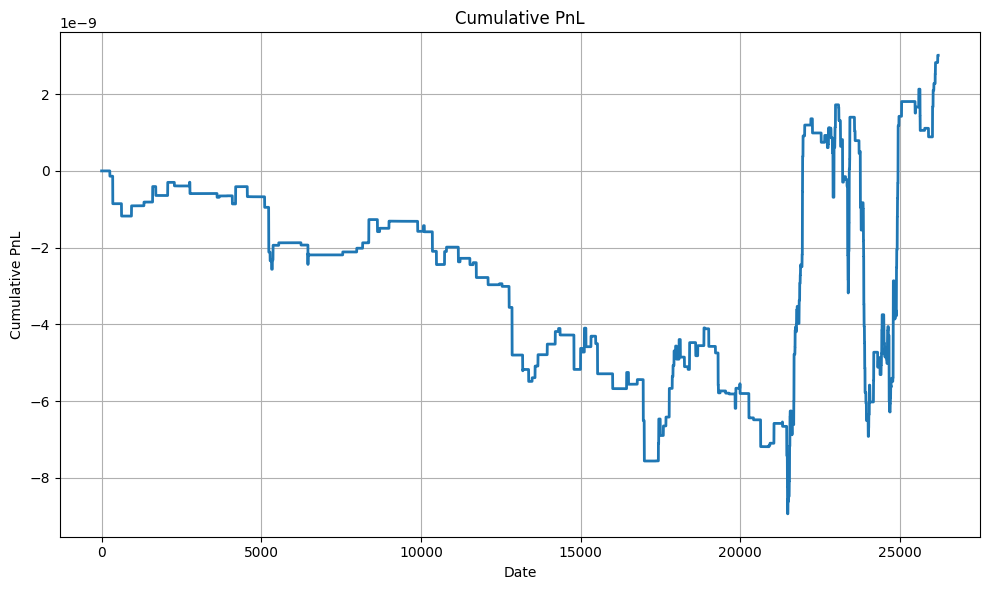

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cum_pnl_series(pnl_series, title='Cumulative PnL', figsize=(10, 6)):
    """
    绘制累计 PnL 曲线。

    参数
    -----
    pnl_series : pandas.Series
        每期的 PnL 序列，索引为日期或时间点。
    title : str, optional
        图表标题，默认 'Cumulative PnL'。
    figsize : tuple, optional
        图表大小，默认为 (10, 6)。
    """
    # 计算累计 PnL
    cum_pnl = pd.Series(pnl_series).cumsum()

    # 绘图
    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(cum_pnl)), cum_pnl.values, linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_pnl_series(pnl_series)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 智能检测你的数据格式
def smart_pnl_plot(pred_returns):
    
    # 转换为numpy数组
    if hasattr(pred_returns, 'cpu'):
        data = pred_returns.cpu().numpy()
    else:
        data = np.array(pred_returns)
    
    print(f"数据形状: {data.shape}")
    
    if data.ndim == 2:
        # 判断是 (时间, 资产) 还是 (资产, 时间)
        if data.shape[0] > data.shape[1]:
            # 假设是 (时间, 资产)
            print("格式: (时间, 资产)")
            avg_returns = np.mean(data, axis=1)  # 每个时间步的平均收益
        else:
            # 假设是 (资产, 时间)
            print("格式: (资产, 时间)")
            avg_returns = np.mean(data, axis=0)  # 每个时间步的平均收益
    else:
        print(f"数据维度: {data.ndim}")
        return None
    
    # 计算累计PnL
    pnl = np.cumsum(avg_returns)
    
    # 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(pnl, linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Portfolio PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"最终PnL: {pnl[-1]:.6f}")
    return pnl



数据形状: (26202, 7)
格式: (时间, 资产)


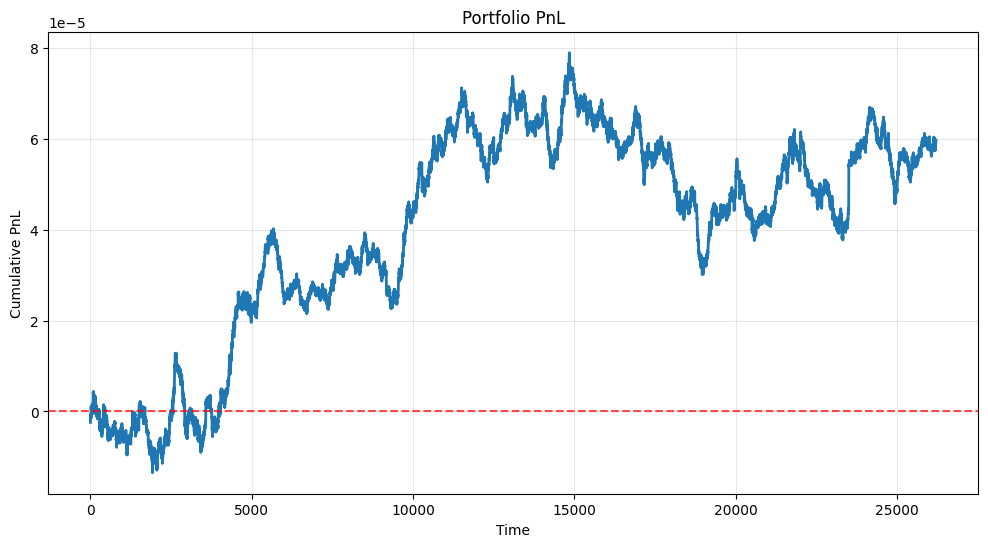

最终PnL: 0.000060


array([-2.3841858e-06, -1.5497208e-06, -1.5497208e-06, ...,
        5.9285012e-05,  5.9370162e-05,  5.9693732e-05], dtype=float32)

In [15]:
# 使用你的数据
smart_pnl_plot(pred_returns_standardized)

数据形状: (26202, 7)
格式: (时间, 资产)


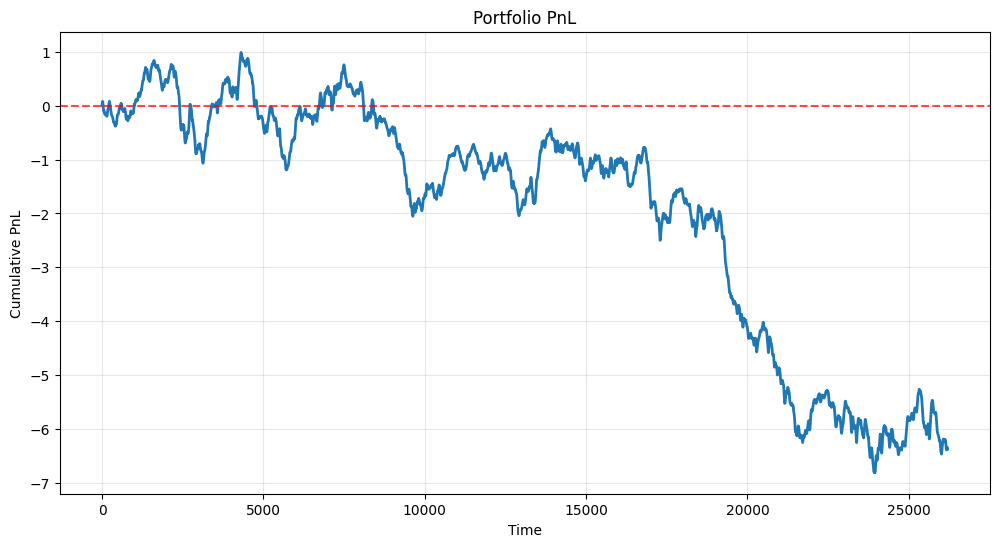

最终PnL: -6.370303


array([ 4.75714733e-03,  1.18718942e-02,  1.95656731e-02, ...,
       -6.36153677e+00, -6.36617806e+00, -6.37030327e+00])

In [16]:
# 使用你的数据
smart_pnl_plot(test_dataset_dict["costs"])